## Yad2 Second hand furniture - can we predict how long it'll take for an item to sell?

For our project we wanted to figure out if we can predict how fast a furniture item will sell on Yad-2 within the span of 5 days of data collection, based on type of furniture, price, condition, amount of pictures uploaded to the ad (if any), and if a decription of the item exists.

We start off with importing libraries relevant for our work, then we defined two functions - one to load our dataframe called 'load_csv' (no surprise there), and one called 'find_mean' to help us out with getting additional information from our existing dataframe.

In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def load_csv(csv):
    df = pd.read_csv(csv, index_col=[0])
    return df

def find_mean(main_df, col1_values, col1, col2):
    col_val_mean_list = []
    col_mean_name = col2 + str(' mean') + ' per ' + col1
    total = main_df[col1].value_counts()
    for item in col1_values:
        col_val_index = []
        col_val_total = 0
        col_val_mean = 0
        for index, row in main_df.iterrows():
            if main_df.at[index, col1] == item:
                col_val_index.append(index)
                col_val_total += main_df.at[index, col2]
        col_val_mean = int(col_val_total / total[item])
        col_val_mean_list.append(col_val_mean)

        for df_index in col_val_index:
            main_df.at[df_index ,col_mean_name] = col_val_mean

    mean_df = pd.DataFrame({col1: col1_values,  col_mean_name: col_val_mean_list})
    return main_df, mean_df

The process begins from loading our dataframe after 6 days of data collection using our crawler (that is in it's own jupyter notebook) - day #1 was collecting 800 ads worth of data, and day #2-#6 was for checking if an ad was sold or not.

In [2]:
df = load_csv("/Users/mayvakrat/Desktop/School Shit/Year 2/Semester B/Introduction To Data Science/Final Project/DF's/full df.csv")


After collecting the data, we narrowed down our records and removed furniture types that had only a 1 digit count in our dataframe, since it's too small of a number to analyze and get any real results.

In [3]:
df['Type'].value_counts()

מיטות                   97
ספות                    96
פינת אוכל               86
סלון                    57
שולחנות                 51
מזנון / ויטרינה         50
ענתיקות                 40
ריהוט לחדרי ילדים       36
ארונות                  36
חדרי שינה               25
שידות                   24
שטיחים                  23
דלתות                   21
כסאות                   21
מטבח                    20
כורסאות                 17
תכולת דירה              16
ריהוט משרדי             14
מדפים                   13
מזרנים                  12
שולחן מחשב              10
כורסאות טלויזיה          8
ספריה                    7
מראה                     6
שולחן טלוויזיה           3
כורסאות ומושבי עיסוי     2
כוורת                    2
מעמד לדיסקים             2
אחר                      1
בר                       1
פוף                      1
שעון קיר                 1
מוטות תלייה              1
Name: Type, dtype: int64

In [4]:
df_clean = df.copy()

list_to_drop = ['מוטות תלייה', 'שעון קיר', 'פוף', 'בר', 'אחר', 'מעמד לדיסקים', 'כוורת', 'כורסאות ומושבי עיסוי', 'שולחן טלוויזיה','מראה','ספריה','כורסאות טלויזיה','תכולת דירה']
for item in list_to_drop:
    df_clean.drop(df_clean.index[df_clean['Type'] == item], inplace=True)

for item in df_clean['Type'].unique():
    print(item)


דלתות
ריהוט לחדרי ילדים
מזנון / ויטרינה
מיטות
ספות
כסאות
סלון
מדפים
פינת אוכל
חדרי שינה
ארונות
כורסאות
שולחנות
שטיחים
מטבח
שולחן מחשב
ענתיקות
ריהוט משרדי
שידות
מזרנים


In addition, for easier access and cohesiveness, we changed our 'Type' column from hebrew to english.

In [5]:
df_clean['Type'] = df_clean['Type'].replace({'מיטות': 'bed'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'ספות': 'couch'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'פינת אוכל': 'dining set'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'סלון': 'living room set'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'שולחנות': 'table'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'מזנון / ויטרינה': 'cupboard'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'ענתיקות': 'antiques'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'ארונות': 'closet'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'ריהוט לחדרי ילדים': 'child bedroom'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'חדרי שינה': 'bedroom'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'שידות': 'dresser'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'שטיחים': 'carpet'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'דלתות': 'door'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'כסאות': 'chair'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'מטבח': 'kitchen'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'כורסאות': 'lounge chair'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'ריהוט משרדי': 'office'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'מדפים': 'shelf'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'מזרנים': 'mattress'}, regex=True)
df_clean['Type'] = df_clean['Type'].replace({'שולחן מחשב': 'desk'}, regex=True)

In [6]:
for item in df_clean['Type'].unique():
    print(item)

door
child bedroom
cupboard
bed
couch
chair
living room set
shelf
dining set
bedroom
closet
lounge chair
table
carpet
kitchen
desk
antiques
office
dresser
mattress


Also changed the 'Condition' column from hebrew to english:

In [7]:
for item in df_clean['Condition'].unique():
    print(item)

חדש באריזה
כמו חדש
משומש
לא רלוונטי
דרוש תיקון/שיפוץ


In [8]:
df_clean['Condition'] = df_clean['Condition'].replace({'חדש באריזה': 'new'}, regex=True)
df_clean['Condition'] = df_clean['Condition'].replace({'כמו חדש': 'used like new'}, regex=True)
df_clean['Condition'] = df_clean['Condition'].replace({'משומש': 'used'}, regex=True)
df_clean['Condition'] = df_clean['Condition'].replace({'לא רלוונטי': 'irrelevant'}, regex=True)
df_clean['Condition'] = df_clean['Condition'].replace({'דרוש תיקון/שיפוץ': 'in need '}, regex=True)

In [9]:
for item in df_clean['Condition'].unique():
    print(item)

new
used like new
used
irrelevant
in need 


Now we calculate how many days it took for each item to sell:

In [10]:
days = ['Is Sold Day #1', 'Is Sold Day #2', 'Is Sold Day #3', 'Is Sold Day #4', 'Is Sold Day #5']
days_until_sold = []
for index, row in df_clean.iterrows():
    day_sold = 1
    for day in days:
        if df_clean.at[index, day] == 0:
            day_sold +=1
    if day_sold == 6:
        days_until_sold.append(-1)
    else:
        days_until_sold.append(day_sold)

df_clean['Days until sold'] = days_until_sold 

For our final dataframe, we will refer to sold units only, therefore we will drop any rows of items that were not sold.

In [11]:
df_clean.drop(df_clean[(df_clean['Days until sold'] == -1)].index, inplace=True)

We also need to clean our dataframe from irrelevant columns:

In [12]:
df_clean.drop(['Link', 'Upload Date', 'Is Sold Day #1', 'Is Sold Day #2', 'Is Sold Day #3', 'Is Sold Day #4','Is Sold Day #5'], axis=1, inplace=True)

In addition - we must change the price column from a string with a currency symbol to an int containing the price only, and removing rows of items which state no price:

In [13]:
df_clean.drop(df_clean.index[df_clean['Price'] == 'לא צוין מחיר'], inplace=True)

In [14]:
df_clean['Price'] = df_clean['Price'].str.strip('₪')
df_clean['Price'] = df_clean['Price'].str.strip(' ')
df_clean['Price'] = df_clean['Price'].str.replace(',', '')
df_clean['Price'] = df_clean['Price'].astype(int)

Next, let's add some columns to our dataframe to help us see if we can our research question:

In [15]:
df_clean, days_mean_type = find_mean(df_clean, sorted(df_clean['Type'].unique()), 'Type', 'Days until sold')
df_clean, days_mean_pic = find_mean(df_clean, sorted(df_clean['Picture count'].unique()), 'Picture count', 'Days until sold')
df_clean, days_mean_condition = find_mean(df_clean, sorted(df_clean['Condition'].unique()), 'Condition', 'Days until sold')
df_clean, days_mean_price = find_mean(df_clean, sorted(df_clean['Price'].unique()), 'Price', 'Days until sold')

In [16]:
df_clean.head()

,Type,Price,Condition,Is description,Picture count,Days until sold,Days until sold mean per Type,Days until sold mean per Picture count,Days until sold mean per Condition,Days until sold mean per Price
0,door,3000,new,yes,4,5,3.0,2.0,3.0,3.0
13,couch,1100,used like new,yes,8,4,2.0,3.0,2.0,4.0
23,child bedroom,750,used,yes,9,1,3.0,1.0,2.0,3.0
25,bed,400,used,yes,4,1,2.0,2.0,2.0,1.0
29,dining set,4000,used like new,yes,10,1,2.0,2.0,2.0,3.0


#### We used bar plots for to visualize a few things:<br>
1.The average amount of days until an item sold per furniture type.<br>
2.The average amount of days until an item sold in correlation to the amount a pictures that were uploaded on the item's ad.<br>
3.The average amount of days until an item sold in correlation to the item's condition.<br>

#### Bar Plot #1:

In [17]:
sorted_type = days_mean_type.copy()
sorted_type = sorted_type.sort_values(by=['Days until sold mean per Type'])

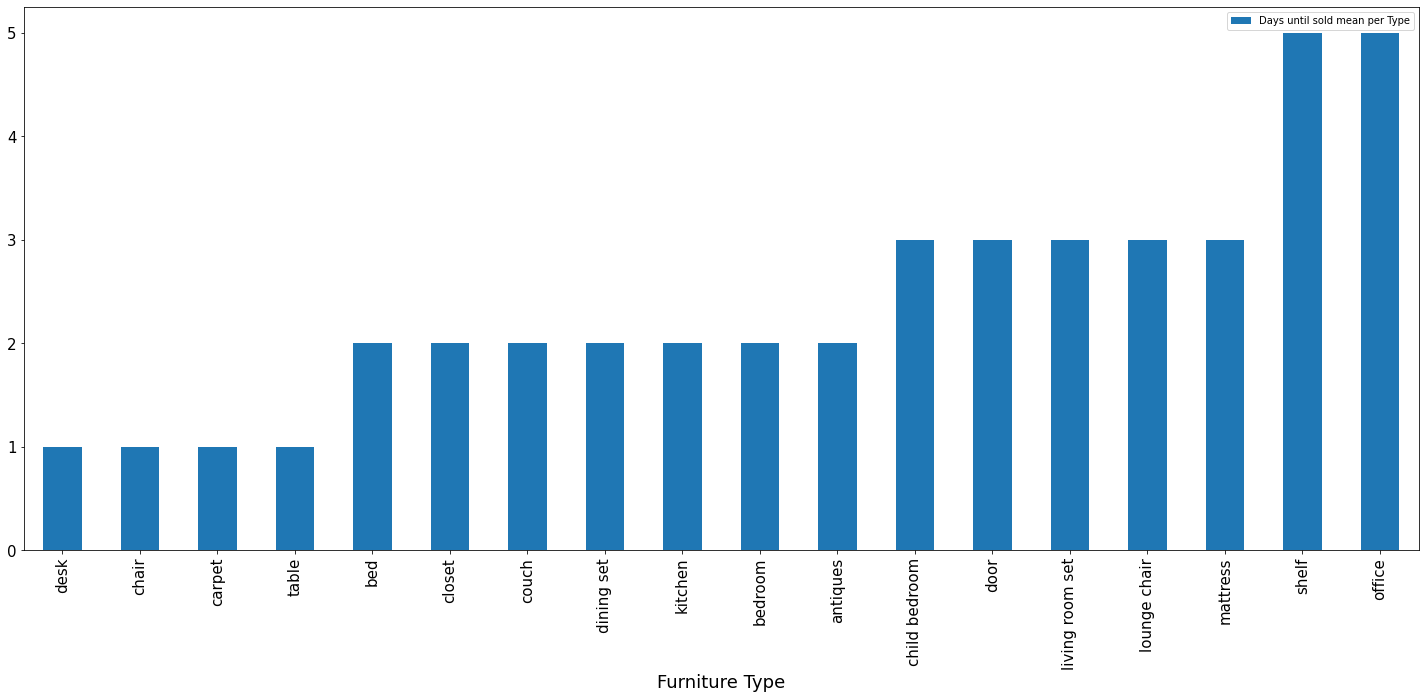

In [18]:
bar_num_1 = sorted_type.plot(kind='bar', x='Type', y='Days until sold mean per Type', figsize=(25,10), fontsize=15)
bar_num_1.set_xlabel('Furniture Type',fontdict={'fontsize':18})
bar_num_1;

Not much we can gather from our bar plot - related catagories are all over the place. Like storage furniture - closets are faster to sell whereas shlefs are not as fast. Desks sells pretty quick, but the office catagory - which might include desks within it, does not.
But what we can see is that a single piece of furniture sells quicker than sets related to that piece - i.e., bed vs. bedrood, couch vs. living room set.

#### Bar Plot #2:

In [19]:
sorted_pic = days_mean_pic.copy()
sorted_pic = sorted_pic.sort_values(by=['Picture count'])

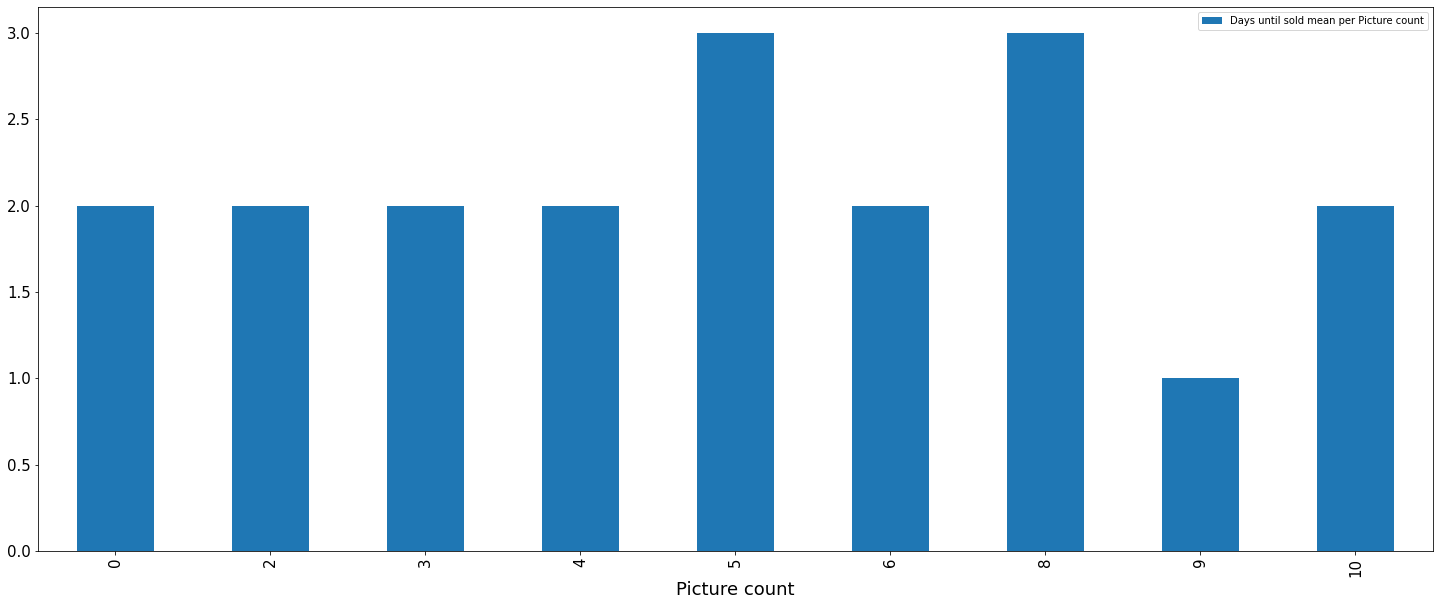

In [20]:
bar_num_2 = sorted_pic.plot(kind='bar', x='Picture count', y='Days until sold mean per Picture count', figsize=(25,10), fontsize=15)
bar_num_2.set_xlabel('Picture count',fontdict={'fontsize':18})
bar_num_2;

As you can see - there is no liniar connection between the amout of pictures on an ad to how fast it was sold.

#### Bar Plot #3:

In [21]:
sorted_condition = days_mean_condition.copy()
sorted_condition = sorted_condition.sort_values(by=['Days until sold mean per Condition'])

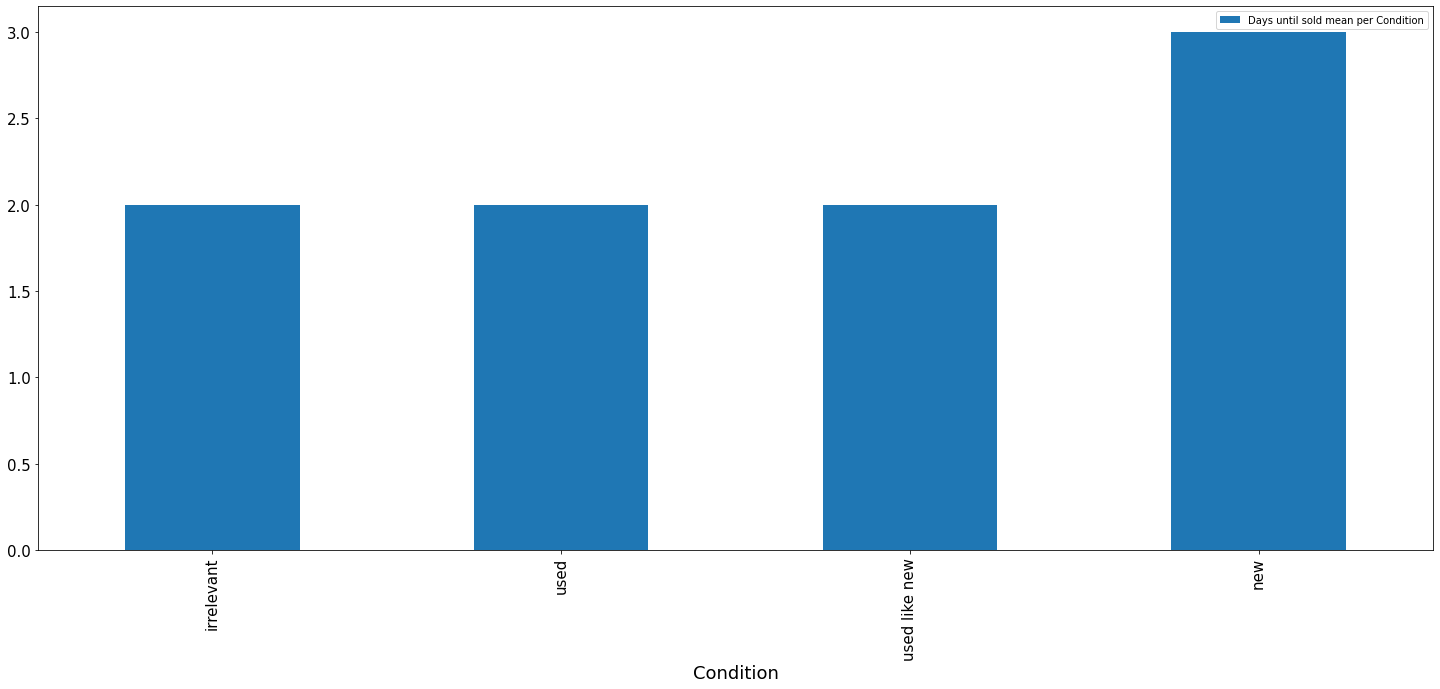

In [22]:
bar_num_3 = sorted_condition.plot(kind='bar', x='Condition', y='Days until sold mean per Condition', figsize=(25,10), fontsize=15)
bar_num_3.set_xlabel('Condition',fontdict={'fontsize':18})
bar_num_3;

It seems that furniture in new condition tend to sell not as fast as others - even the 'irrelevant' condition, which essentially means no condition stated.
This might be related to newer items being more expensive, so let's check 'Price' next.

We do that by using a line plot to visualize the time period until a unit was sold in correlation to its price.

In [23]:
sorted_price = days_mean_price.copy()
sorted_price = sorted_price.sort_values(by='Price')

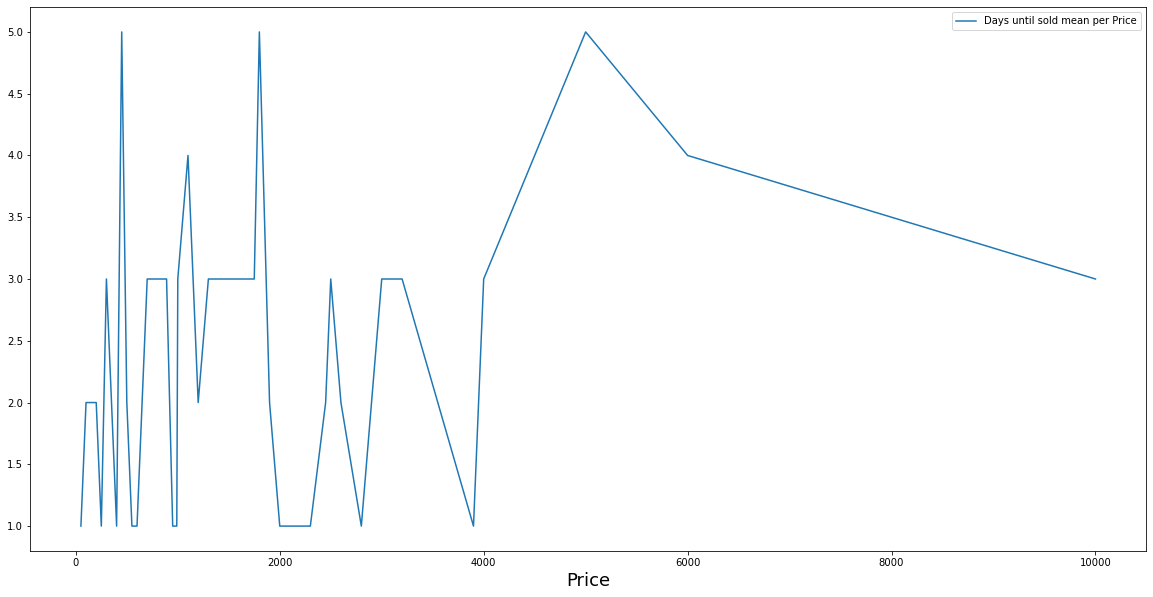

In [24]:
line_plot1 = sorted_price.plot(kind='line', x='Price', y='Days until sold mean per Price', figsize=(20,10), fontsize=10)
line_plot1.set_xlabel('Price',fontdict={'fontsize':18})
line_plot1;

Now let's see if the item's price in regard to the item's type price mean has a correlation to how fast it was sold.
First, we find the price mean for each type of furniture and add that column to our dataframe.

In [25]:
df_clean, price_mean_type = find_mean(df_clean, sorted(df_clean['Type'].unique()), 'Type', 'Price')

In [26]:
df_clean.head()

,Type,Price,Condition,Is description,Picture count,Days until sold,Days until sold mean per Type,Days until sold mean per Picture count,Days until sold mean per Condition,Days until sold mean per Price,Price mean per Type
0,door,3000,new,yes,4,5,3.0,2.0,3.0,3.0,810.0
13,couch,1100,used like new,yes,8,4,2.0,3.0,2.0,4.0,2819.0
23,child bedroom,750,used,yes,9,1,3.0,1.0,2.0,3.0,1050.0
25,bed,400,used,yes,4,1,2.0,2.0,2.0,1.0,1150.0
29,dining set,4000,used like new,yes,10,1,2.0,2.0,2.0,3.0,1841.0


We have the mean for each type, now we add a column to our main dataframe that holds the price of the item compared to its type mean

In [27]:
price_to_mean_list = []
price_to_mean = 0.0

for index, row in df_clean.iterrows():
    price_to_mean = format((df_clean.at[index, 'Price'] / df_clean.at[index, 'Price mean per Type']), '.2f')
    price_to_mean_list.append(price_to_mean)
    
df_clean['Price compared to type mean'] = price_to_mean_list

In [28]:
df_clean.head()

,Type,Price,Condition,Is description,Picture count,Days until sold,Days until sold mean per Type,Days until sold mean per Picture count,Days until sold mean per Condition,Days until sold mean per Price,Price mean per Type,Price compared to type mean
0,door,3000,new,yes,4,5,3.0,2.0,3.0,3.0,810.0,3.70
13,couch,1100,used like new,yes,8,4,2.0,3.0,2.0,4.0,2819.0,0.39
23,child bedroom,750,used,yes,9,1,3.0,1.0,2.0,3.0,1050.0,0.71
25,bed,400,used,yes,4,1,2.0,2.0,2.0,1.0,1150.0,0.35
29,dining set,4000,used like new,yes,10,1,2.0,2.0,2.0,3.0,1841.0,2.17


We are done gathering information and calculating - now, we can build another line plot:

In [29]:
sorted_price_mean = df_clean.copy()
sorted_price_mean = sorted_price_mean.sort_values(by='Price compared to type mean')

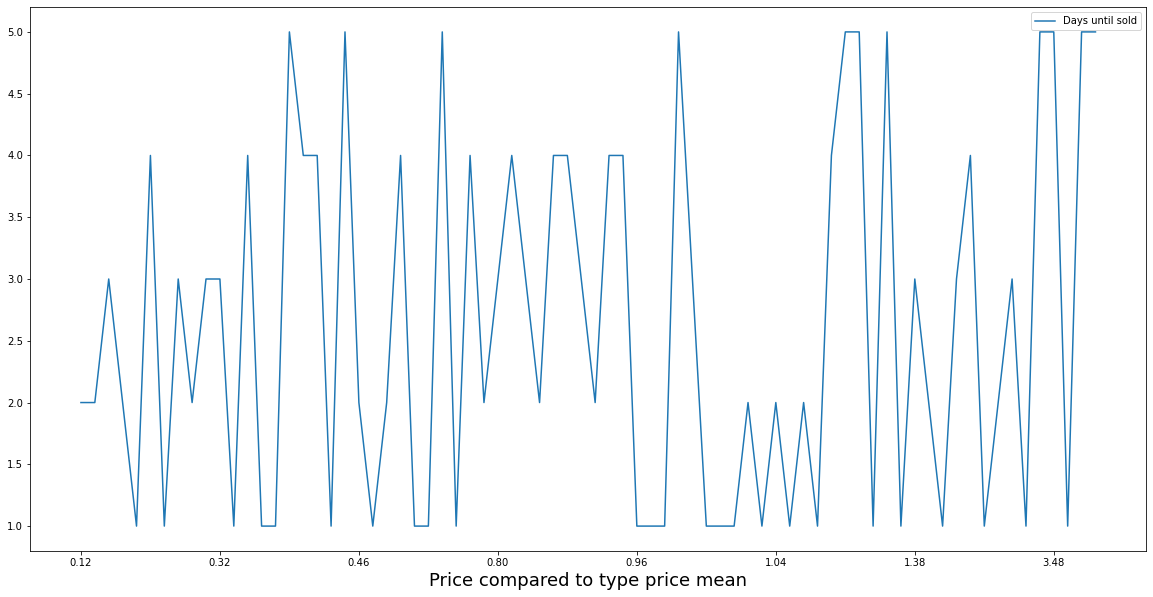

In [30]:
line_plot2 = sorted_price_mean.plot(kind='line', x='Price compared to type mean', y='Days until sold', figsize=(20,10), fontsize=10)
line_plot2.set_xlabel('Price compared to type price mean',fontdict={'fontsize':18})
line_plot2;

### Data preperation for maching learning

We have all our data, now we have to change catagorical variables to numerical in order to scale and apply a linear regression model on our data.
For our condition map - we associate each catagory with a number between 0 - 4, 0 - being the worst condition & 4 - being the best condition.
For our description map - existent description is replaced with the number 1, and non-existent with the number 0.
And for our final catatgorical value - type, we change each entry with the amount of items existing of that type in the dataframe.

In [31]:
condition_replace_map = {'irrelevant': 0, 'in need of a fix': 1, 'used': 2, 'used like new': 3, 'new': 4}
df_clean = df_clean.replace({'Condition': condition_replace_map}, regex=True)
description_replace_mape = {'yes': 1, 'no': 0}
df_clean = df_clean.replace({'Is description': description_replace_mape}, regex=True)

type_value_count = []
for index, row in df_clean.iterrows():
    type_value_count.append(df_clean['Type'].value_counts()[df_clean.at[index, 'Type']])

df_clean['Type'] = type_value_count

In [32]:
df_clean

,Type,Price,Condition,Is description,Picture count,Days until sold,Days until sold mean per Type,Days until sold mean per Picture count,Days until sold mean per Condition,Days until sold mean per Price,Price mean per Type,Price compared to type mean
0,5,3000,4,1,4,5,3.0,2.0,3.0,3.0,810.0,3.70
13,15,1100,2,1,8,4,2.0,3.0,2.0,4.0,2819.0,0.39
23,6,750,2,1,9,1,3.0,1.0,2.0,3.0,1050.0,0.71
25,13,400,2,1,4,1,2.0,2.0,2.0,1.0,1150.0,0.35
29,6,4000,2,1,10,1,2.0,2.0,2.0,3.0,1841.0,2.17
...,...,...,...,...,...,...,...,...,...,...,...,...
749,4,250,0,1,2,2,2.0,2.0,2.0,1.0,1812.0,0.14
768,5,100,2,1,0,2,3.0,2.0,2.0,2.0,810.0,0.12
792,2,50,2,1,0,2,1.0,2.0,2.0,1.0,50.0,1.00
796,1,450,2,1,0,5,5.0,2.0,2.0,5.0,450.0,1.00


#### Now it's time to put our data to the test and really see if we can predict  the time period an item will sell?

We start by splitting our dataframe to train & test:

In [33]:
X = df_clean.drop(['Days until sold'], axis=1)
y = df_clean['Days until sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

Next we scale our data:

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Lastly, we apply a linear regression model on our scaled train set, and use predict on our test set, and evaluate our work.

In [35]:
trained_model = LinearRegression()
trained_model.fit(X_train_scaled, y_train)
predicted_vals = trained_model.predict(X_test_scaled)
evaluate_value = metrics.r2_score(y_test, predicted_vals)

We used R² evaluation method to check how well our model can predict the time period an item will sell:

In [36]:
evaluate_value

0.5556478736200203

Since R² > 0.5, it seems the efficancy of our model is quite good! Hurray!